# Convert ArchR to Signac

In [ ]:
.libPaths("/hwfssz1/ST_SUPERCELLS/Reference/software/miniconda3_py3.9/lib/R/library")
library(ArchR)
library(parallel)
library(Seurat)
library(Signac)
library(stringr)
library(future)
options(future.globals.maxSize = 50 * 1024^3)
plan("multisession", workers = 22)
args<-commandArgs(T)

proj <- readRDS(args[1])
fragpaths=list.files(args[2],".tsv.gz$")
setwd(args[2])
pk=getPeakSet(proj)


###### extract barcode from ATAC project #########
meta=as.data.frame(proj@cellColData)
row=rownames(meta)
df.meta=c()
for(i in row){
i=strsplit(i,"#",fixed=T)
i=i[[1]][2]
df.meta=c(df.meta,i) 
}
rownames(meta)=df.meta

#meta = read.table("/hwfssz5/ST_SUPERCELLS/P22Z10200N0639/jinbufan/jbf/AD/proj1.cellColData.meta.txt",header=T,stringsAsFactors=F,sep="\t")


######### create signac project #########
######### extract same barcode from fragments file ############
human.list=list()
for(i in 1:16){
fragpath = fragpaths[i]
fragcounts <- CountFragments(fragments = fragpath)
#fragcounts = fragcounts[fragcounts$frequency_count>2000,]
fragcounts =  fragcounts[which(fragcounts$CB %in% rownames(meta)),]
rownames(fragcounts) = fragcounts$CB
frags.obj <- CreateFragmentObject(path = fragpath,cells = fragcounts$CB)
sample.counts <- FeatureMatrix(fragments = frags.obj,features = pk,cells = fragcounts$CB)
sample_assay <- CreateChromatinAssay(sample.counts, fragments = frags.obj)
sample.obj <- CreateSeuratObject(sample_assay, assay = "ATAC_", meta.data=meta[fragcounts$CB,])
sample.obj$Sample = fragpaths[i]
human.list[[i]] = sample.obj
}
saveRDS(human.list,"/hwfssz5/ST_SUPERCELLS/P22Z10200N0639/jinbufan/ATAC/16librarys.signac.obj.rds")

scRNAlist=human.list
seurat_atac <- merge(scRNAlist[[1]], y=c(scRNAlist[[2]], scRNAlist[[3]],scRNAlist[[4]], scRNAlist[[5]], scRNAlist[[6]], scRNAlist[[7]],scRNAlist[[8]], scRNAlist[[9]], scRNAlist[[10]],scRNAlist[[11]], scRNAlist[[12]],scRNAlist[[13]], scRNAlist[[14]], scRNAlist[[15]], scRNAlist[[16]]))
#seurat_atac <- readRDS("/hwfssz5/ST_SUPERCELLS/P20Z10200N0059/liuyuyang/jbf/01.brain.Integrate/signac_final.rds")
#gsm <- getGeneScoreMatrix(ArchRProject = proj, SeuratObject = seurat_atac)
#seurat_atac[['RNA']] <- CreateAssayObject(counts = gsm)


########## add genome annotation ############
library(EnsDb.Hsapiens.v86)
annotations <- GetGRangesFromEnsDb(EnsDb.Hsapiens.v86)
seqlevels(annotations) <- paste0('chr', seqlevels(annotations))
genome(annotations) <- "hg38"
Annotation(seurat_atac[["ATAC_"]]) <- annotations

seurat_atac <- RunTFIDF(seurat_atac)
seurat_atac <- FindTopFeatures(seurat_atac, min.cutoff = "q0")
seurat_atac <- RunSVD(seurat_atac)
seurat_atac <- RunUMAP(seurat_atac, reduction = "lsi", dims = 2:30, reduction.name = "umap.atac", reduction.key = "atacUMAP_")

########## add gene matrix ###########
proj_rna <- readRDS("/hwfssz5/ST_SUPERCELLS/P22Z10200N0639/jinbufan/RNA/human.rds")
gene.activities <- GeneActivity(seurat_atac, features = VariableFeatures(proj_rna))
# add gene activities as a new assay
seurat_atac[["ACTIVITY"]] <- CreateAssayObject(counts = gene.activities)

########## add motif matrix from ArchR project ###########
seurat_atac[["motif"]] <- CreateAssayObject(counts = motif_mat)


# saveRDS(seurat_atac,"/hwfssz5/ST_SUPERCELLS/P22Z10200N0639/jinbufan/ATAC/signac.rds")
saveRDS(seurat_atac,"/data/work/previous/Integrate/humanFL_signac_homer.rds")

# Processing Signac project

In [1]:
suppressPackageStartupMessages(library("Seurat"))
suppressPackageStartupMessages(library("GenomicRanges"));
suppressPackageStartupMessages(library("RColorBrewer"))
suppressPackageStartupMessages(library("viridis"))
suppressPackageStartupMessages(library("ggplot2"))
suppressPackageStartupMessages(library("reshape2"))
suppressPackageStartupMessages(library("pheatmap"))
suppressPackageStartupMessages(library("data.table"))
suppressPackageStartupMessages(library("plyr"))
motifset = "homer"

Warning message:
“package ‘viridis’ was built under R version 4.2.3”
Warning message:
“package ‘viridisLite’ was built under R version 4.2.3”
Warning message:
“package ‘reshape2’ was built under R version 4.2.3”
Warning message:
“package ‘pheatmap’ was built under R version 4.2.3”
Warning message:
“package ‘data.table’ was built under R version 4.2.3”


In [2]:
outF <- "/data/work/previous/Integrate/"

In [8]:
macaca <- readRDS("/data/work/previous/Integrate/macacaFL_signac_homer.rds")

In [7]:
mouse <- readRDS(paste0("/data/work/previous/CTX_额叶_scATAC_ArchRProj/Signac_Proj/mouse_CTXadav_signac_",motifset,".rds"))

In [95]:
DefaultAssay(macaca) <- "motif"
DefaultAssay(mouse) <- "motif"

In [96]:
mouse <- ScaleData(mouse,verbose = FALSE)

In [98]:
macaca <- ScaleData(macaca,verbose = FALSE)

In [97]:
macaca@meta.data$set <- "macaca"
mouse@meta.data$set <- "mouse"

In [99]:
mouse.feature <- rownames(mouse[["motif"]])
mouse <- RunPCA(mouse, features = mouse.feature,)
macaca.feature <- rownames(macaca[["motif"]])
macaca <- RunPCA(macaca, features = macaca.feature)

PC_ 1 
Positive:  BARHL2-1074, BARHL1-1073, POU3F1-1216, EMX2-1735, DBX2-1087, MSX2-1178, VENTX-1895, EN1-1737, EN1-1739, POU1F1-1212 
	   BARX2-1076, LHX6-1167, LHX3-1163, ISL2-1158, NFY-430, LHX8-1168, PRRX2-353, BARHL2-1708, HMX3-1113, ZFX-926 
	   NKX1.2-1180, LMX1B-1171, NOBOX-912, GBX2-1750, HOXC6-1141, NKX6.1-1189, POU3F4-1219, EMX1-1733, EN2-1099, HOXD8-1150 
Negative:  ZNF354C-913, TBX15-1509, MGA-1503, TBX5-789, TBX5-1529, TBX20-2060, TBX21-1523, TBX5-775, TBX21-1520, TBX20-1515 
	   TBR1-1506, TBX20-1518, FOXO3-1676, TBX1-1513, EOMES-1501, SMAD-683, TBX1-1511, NEUROG2-1579, GTF2I-635, TBX20-1517 
	   TBX2-1526, FOXO1-1673, EOMES-977, ATOH1-1554, BHLHE23-1559, TBR1-1507, BHLHE22-1558, EGR1-952, TBX4-1527, OLIG1-1583 
PC_ 2 
Positive:  ETS-299, EGR1-156, ELF5-1332, ETS-741, ELF5-1333, ELF5-1355, BCL-27, ETV4-618, SPI1-955, ETS-672 
	   SPI1-34, ETV6-1354, NFE2L2-358, ETS-21, SPI1-1022, ELF1-658, ETS-491, ETV6-1353, ETS-492, ETV2-1349 
	   ETS-307, SPI1-620, SPIB-1370, ELF3-133

In [105]:
macaca =  FindVariableFeatures(macaca, selection.method = "vst")

Warning message in eval(predvars, data, env):
“NaNs produced”
Warning message in hvf.info$variance.expected[not.const] <- 10^fit$fitted:
“number of items to replace is not a multiple of replacement length”


In [106]:
mouse =  FindVariableFeatures(mouse, selection.method = "vst")

Warning message in eval(predvars, data, env):
“NaNs produced”
Warning message in hvf.info$variance.expected[not.const] <- 10^fit$fitted:
“number of items to replace is not a multiple of replacement length”


In [ ]:
saveRDS(macaca,paste0(outF,"macacaFL_signac_",motifset,".rds"))
saveRDS(mouse,paste0("/data/work/previous/CTX_额叶_scATAC_ArchRProj/Signac_Proj/","mouse_CTXadav_signac_",motifset,".rds"))

# three species combined

In [ ]:
human <- readRDS(paste0("/data/work/previous/Integrate/humanFL_signac_",motifset,".rds"))

In [107]:
se.lst <- list(mouse, macaca, human)

In [41]:
se.lst

[[1]]
An object of class Seurat 
448770 features across 35176 samples within 3 assays 
Active assay: motif (332 features, 332 variable features)
 3 layers present: counts, data, scale.data
 2 other assays present: peaks, ACTIVITY
 4 dimensional reductions calculated: UMAPHarmony, IterativeLSI, harmony, pca

[[2]]
An object of class Seurat 
382263 features across 68931 samples within 3 assays 
Active assay: motif (332 features, 332 variable features)
 3 layers present: counts, data, scale.data
 2 other assays present: peaks, ACTIVITY
 4 dimensional reductions calculated: UMAPHarmony, IterativeLSI, harmony, pca

[[3]]
An object of class Seurat 
389934 features across 57331 samples within 3 assays 
Active assay: motif (332 features, 332 variable features)
 3 layers present: counts, data, scale.data
 2 other assays present: peaks, ACTIVITY
 4 dimensional reductions calculated: UMAPHarmony, IterativeLSI, harmony, pca


In [43]:
se.anchors <- FindIntegrationAnchors(object.list = se.lst)

Computing 2000 integration features

Scaling features for provided objects

Finding all pairwise anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 99908 anchors

Filtering anchors

	Retained 22591 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 85362 anchors

Filtering anchors

	Retained 19699 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 134996 anchors

Filtering anchors

	Retained 43177 anchors



In [44]:
#se.features <- intersect(rownames(mouse[["motif"]]),rownames(macaca[["motif"]]), rownames(human[["motif"]]))
#se.anchors <- FindIntegrationAnchors(object.list = se.lst)#, anchor.features = se.features)
se.combined <- IntegrateData(anchorset = se.anchors)

Merging dataset 3 into 2

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Merging dataset 1 into 2 3

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data



In [45]:
# Perform an integrated analysis
DefaultAssay(se.combined) <- "integrated"

# Run the standard workflow for visualization and clustering
se.combined <- ScaleData(se.combined, verbose = FALSE)
se.combined <- RunPCA(se.combined, npcs = 50, verbose = FALSE)
#ElbowPlot(se.combined, ndims = 50)
se.combined <- RunUMAP(se.combined, reduction = "pca", dims = 1:30)
se.combined <- FindNeighbors(se.combined, reduction = "pca", dims = 1:30)
se.combined <- FindClusters(se.combined, resolution = 0.5)

#DimPlot(se.combined, reduction = "umap", group.by = c("set", "cluster"))
#DimPlot(se.combined, reduction = "umap", group.by = c("queryCluster", "refCluster"))

saveRDS(se.combined, file=paste0(outF, "human_macaca_mouse_coembed_",motifset,".rds"))

21:20:07 UMAP embedding parameters a = 0.9922 b = 1.112

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

21:20:07 Read 161438 rows and found 30 numeric columns

21:20:07 Using Annoy for neighbor search, n_neighbors = 30

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

21:20:07 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

21:20:30 Writing NN index file to temp file /tmp/RtmpoN6NfM/file1f27366e259

21:20:30 Searching Annoy index using 1 thread, search_k = 3000

21:21:46 Annoy recall = 100%

21:21:51 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

21:22:00 Initializing from normalized Laplacian + 

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 161438
Number of edges: 3557723

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9181
Number of communities: 28
Elapsed time: 94 seconds


10 singletons identified. 18 final clusters.



In [6]:
pdf(paste0(outF, "human_macaca_mouse_coembed.umap_",motifset,"_plot4.pdf"), width = 28, height=40)
DimPlot(se.combined, group.by = c("CellType","fineClust", "FineClust"),split.by= "set", label = T,raster=FALSE,repel = TRUE) + 
  theme(legend.position = "top") + guides(color = guide_legend(nrow = 4, byrow = TRUE,
    override.aes = list(size = 2.5)))
dev.off()

Warning message:
“Removed 23 rows containing missing values (`geom_text_repel()`).”
Warning message:
“Removed 20 rows containing missing values (`geom_text_repel()`).”
Warning message:
“Removed 20 rows containing missing values (`geom_text_repel()`).”


png 
  2

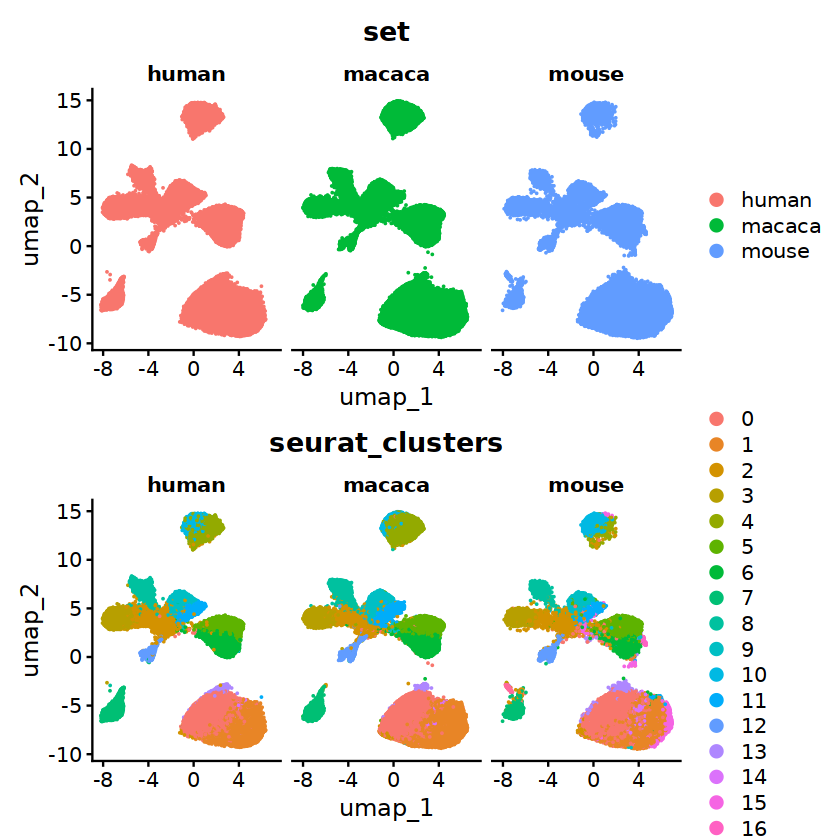

In [47]:
DimPlot(se.combined, reduction = "umap", group.by = c("set", "seurat_clusters"),split.by= "set",raster=FALSE)

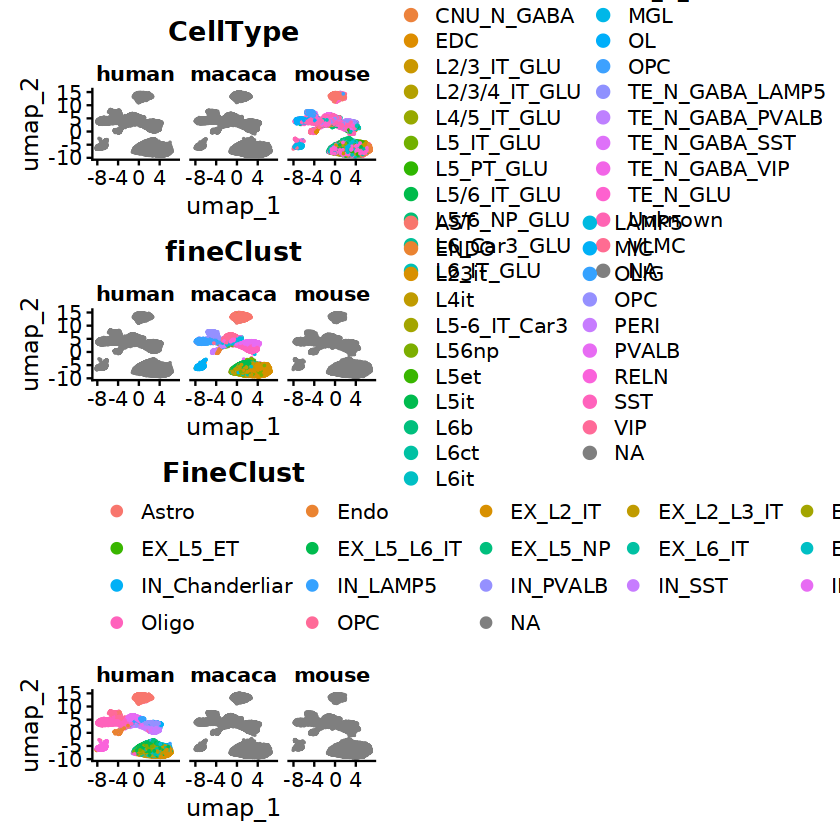

In [48]:
DimPlot(se.combined, group.by = c("CellType","fineClust", "FineClust"),split.by= "set",raster=FALSE) + 
  theme(legend.position = "top") + guides(color = guide_legend(nrow = 4, byrow = TRUE,
    override.aes = list(size = 2.5)))